In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [26]:
# Training params
TRAIN_TEST_SPLIT = 0.1
BATCH_SIZE = 4

In [53]:
# Grab training data

squares = np.load("squares.npy")
train_squares = squares[: int(len(squares) * (1 - TRAIN_TEST_SPLIT))]
test_squares = squares[int(len(squares) * (1 - TRAIN_TEST_SPLIT)) :]
print(f"train squares: {train_squares.shape}, test squares: {test_squares.shape}")
circles = np.load("circles.npy")
train_circles = circles[: int(len(circles) * (1 - TRAIN_TEST_SPLIT))]
test_circles = circles[int(len(circles) * (1 - TRAIN_TEST_SPLIT)) :]
print(f"train circles: {train_circles.shape}, test circles: {test_circles.shape}")

train_data = np.concatenate((train_squares, train_circles))
test_data = np.concatenate((test_squares, test_circles))

# Add a channel dimension, using expand_dims
train_data = np.expand_dims(train_data, axis=-1).astype("float32")
test_data = np.expand_dims(test_data, axis=-1).astype("float32")

print(f"train data: {train_data.shape}, test data: {test_data.shape}")

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_data).shuffle(60000).batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_data).shuffle(60000).batch(BATCH_SIZE)
)


train squares: (180, 64, 64), test squares: (20, 64, 64)
train circles: (180, 64, 64), test circles: (20, 64, 64)
train data: (360, 64, 64, 1), test data: (40, 64, 64, 1)


In [54]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim: int, input_image_shape: tuple):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_image_shape = input_image_shape

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.input_image_shape, self.input_image_shape, 1)),
                tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
                tf.keras.layers.Flatten(),
                #  No activation since we need the raw latent vector
                tf.keras.layers.Dense(latent_dim + latent_dim),
                # The latent vector is split into two vectors, one for mean and one for variance
                # The model knows that the first half of the latent vector is for mean and the second half is for variance because
                # we pass the output of the dense layer through a Lambda layer that splits the vector so it learns to split the vector
                # into two parts as such
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(
                    units=input_image_shape // 4 * input_image_shape // 4 * 32,
                    activation=tf.nn.relu,
                ),
                #  This layer is the inverse of the Flatten layer in the encoder
                # It takes the latent vector and reshapes it into a tensor, where the shape is the same as the output of the encoder
                # Which depending on the convolutional layers and input shape, is 1/n of the input shape where n is the number of strides
                # in the convolutional layers
                # The activation function is relu because we want to avoid negative values
                tf.keras.layers.Reshape(target_shape=(input_image_shape // 4, input_image_shape // 4, 32)),
                # The reshape layer takes the output of the dense layer and reshapes it into a tensor
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                # The output of the last convolutional layer is the same shape as the input
                # These layers are the inverse of the convolutional layers in the encoder, they take the tensor and expand it, turning
                # it into an image
                # The activation function is relu because we want to avoid negative values
                # The padding is SAME because we want the output to be the same size as the input
                tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
                # The output of the last convolutional layer is the same shape as the input
                # It doesn't have an activation function because we want the output to be the raw pixel values
            ]
        )

    def encode(self, x):
        """Encode the input image into a latent vector.

        Parameters:
        -----------
        x : tf.Tensor
            Input image, in the form of a tensor of shape (batch_size, 28, 28, 1).

        Returns:
        --------
        mean, logvar : tf.Tensor, tf.Tensor
            Mean and log of the variance of the latent distribution, in the form of tensors of shape (batch_size, latent_dim).
            The mean and log of the variance are calculated by the encoder network, and are used to sample from the latent distribution.

        """
        # Split the output of the encoder into two vectors, one for mean and one for variance
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        """Reparameterize the latent distribution using the mean and log of the variance. This is done using the reparameterization trick,
        where the latent vector is sampled from the distribution using a random noise tensor. This is done to ensure that the gradients can
        be backpropagated through the sampling operation, as the gradients cannot flow through a random node. This is not a problem when using
        the reparameterization trick because the gradients can flow through the mean and log of the variance because they are deterministic
        as opposed to if the latent vector was sampled directly from a randome node.

        Parameters:
        -----------
        mean : tf.Tensor
            Mean of the latent distribution, in the form of a tensor of shape (batch_size, latent_dim).
        logvar : tf.Tensor
            Log of the variance of the latent distribution, in the form of a tensor of shape (batch_size, latent_dim).

        Returns:
        --------
        z : tf.Tensor
            Sampled latent vector, used to generate a new image.

        """
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        """Decode the latent vector into an image.

        Parameters:
        -----------
        z : tf.Tensor
            Latent vector, in the form of a tensor of shape (batch_size, latent_dim).
        apply_sigmoid : bool, optional
            Whether to apply the sigmoid function to the output, in the form of a boolean. Default is False.

        Returns:
        --------
        x : tf.Tensor
            Decoded image, in the form of a tensor of shape (batch_size, 28, 28, 1).

        """
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    # The sample method is used to sample from the posterior distribution, meaning it samples from the distribution of the latent vector
    @tf.function
    def sample(self, eps=None):
        """Sample from the posterior distribution using reparameterization trick, where `eps` is a random noise tensor and `z` is the latent vector.

        If `eps` is not provided, it will be sampled from `N(0, I)`.

        Parameters:
        -----------
        eps : tf.Tensor, optional
            Random noise to sample from the distribution, in the form of a tensor of shape (batch_size, latent_dim), values between 0 and 1. If not provided, it will be sampled from `N(0, I)`.


        Returns:
        --------
        z : tf.Tensor
            Sampled latent vector, used to generate a new image.

        """
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

## Loss function

VAEs are trained using the evidence lower bound (ELBO), which is the sum of the reconstruction loss and the KL divergence.

- KL is used to measure how closely the latent vectors match a standard normal distribution. This is done to ensure that the latent vectors are close to a standard normal distribution, which makes sampling from the latent space easier.
- The reconstruction loss is used to measure how well the model can reconstruct the input image from the latent vector. This is done to ensure that the model can generate images that are similar to the input images.

TODO: Learn how this works properly at the mathematical level.



In [55]:
# optimizer = tf.keras.optimizers.Adam(1e-4)
optimizer = tf.keras.optimizers.legacy.Adam(1e-4)


def log_normal_pdf(sample: tf.Tensor, mean: tf.Tensor, logvar: tf.Tensor, raxis=1) -> tf.Tensor:
    """Calculate the log probability density function of a sample given the mean and log of the variance of the distribution.

    The log probability density funcition is used to calculate the loss of the model, which is used to train the model.

    This is done using the formula:
    log_prob = -0.5 * ((sample - mean) ** 2 * exp(-logvar) + logvar + log(2 * pi))



    Parameters:
    -----------
    sample : tf.Tensor
        Sample from the distribution, in the form of a tensor of shape (batch_size, latent_dim).
    mean : tf.Tensor
        Mean of the distribution, in the form of a tensor of shape (batch_size, latent_dim).
    logvar : tf.Tensor
        Log of the variance of the distribution, in the form of a tensor of shape (batch_size, latent_dim).
    raxis : int, optional
        Axis to reduce over when calculating the log probability density function, in the form of an integer. Default is 1.

    Returns:
    --------
    log_prob : tf.Tensor
        Log probability density function of the sample, given the mean and log of the variance of the distribution, in the form of a tensor of shape (batch_size,).

    """
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model: tf.keras.Model, x: tf.Tensor) -> tf.Tensor:
    """Calculate the loss of the model, which is used to train the model.

    This is done using the formula:
    loss = -E[log(p(x|z))] + KL(q(z|x) || p(z))

    Where:
    - E[log(p(x|z))] is the expected log likelihood of the data given the latent vector, which is the reconstruction loss.
    - KL(q(z|x) || p(z)) is the Kullback-Leibler divergence between the approximate posterior and the prior, which is the regularization loss.

    The loss is calculated by first encoding the input image into a mean and log of the variance of the latent distribution, then sampling from the distribution using the reparameterization trick.
    The sampled latent vector is then decoded into an image, which is used to calculate the reconstruction loss.
    The regularization loss is calculated using the mean and log of the variance of the latent distribution.

    Parameters:
    -----------
    model : tf.keras.Model
        Model to calculate the loss of, in the form of a tf.keras.Model.
    x : tf.Tensor
        Input image, in the form of a tensor of shape (batch_size, 28, 28, 1).

    Returns:
    --------
    loss : tf.Tensor
        Loss of the model, in the form of a tensor of shape ().
    """

    mean, logvar = model.encode(
        x
    )  # Encode the input image into a mean and log of the variance of the latent distribution
    z = model.reparameterize(mean, logvar)  # Sample from the latent distribution using the reparameterization trick
    x_logit = model.decode(z)  # Decode the latent vector into an image
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
        logits=x_logit, labels=x
    )  # Calculate the cross entropy loss between the input image and the decoded image
    logpx_z = -tf.reduce_sum(
        cross_ent, axis=[1, 2, 3]
    )  # Calculate the log likelihood of the data given the latent vector, which is the reconstruction loss (negative log likelihood).
    # This is done by summing the cross entropy loss over the height and width of the image, and then summing over the batch size.
    logpz = log_normal_pdf(
        z, 0.0, 0.0
    )  # Calculate the log probability density function of the sample given the mean and log of the variance of the distribution, which is the log of the prior.
    # This is used to calculate the regularization loss. The mean and log of the variance of the prior are both 0, as the prior is a standard normal distribution.
    logqz_x = log_normal_pdf(
        z, mean, logvar
    )  # Calculate the log probability density function of the sample given the mean and log of the variance of the distribution, which is the log of the approximate posterior.
    # Reminder: The log probability density function of a sample is the log of the probability of the sample occuring in a specific range of values.
    # So we have calculated:
    # - The log likelihood of the data given the latent vector, which is the reconstruction loss (how well the model can reconstruct the input image).
    # - The log of the prior, which is used to calculate the regularization loss.
    # - The log of the approximate posterior, which is used to calculate the regularization loss (how well the approximate posterior matches the prior, where the prior is a standard normal distribution).

    return -tf.reduce_mean(
        logpx_z + logpz - logqz_x
    )  # Calculate the loss of the model, which is used to train the model. The loss is calculated using the formula: loss = -E[log(p(x|z))] + KL(q(z|x) || p(z))


@tf.function
def train_step(model: tf.keras.Model, x: tf.Tensor, optimizer: tf.keras.optimizers.Optimizer) -> tf.Tensor:
    """Train the model using a single batch of input images.

    This is done by calculating the loss of the model, which is used to train the model.

    Parameters:
    -----------
    model : tf.keras.Model
        Model to train, in the form of a tf.keras.Model.
    x : tf.Tensor
        Input image, in the form of a tensor of shape (batch_size, 28, 28, 1).
    optimizer : tf.keras.optimizers.Optimizer
        Optimizer to use to train the model, in the form of a tf.keras.optimizers.Optimizer.

    Returns:
    --------
    loss : tf.Tensor
        Loss of the model, in the form of a tensor of shape ().
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)  # Calculate the loss of the model, which is used to train the model.
    gradients = tape.gradient(
        loss, model.trainable_variables
    )  # Calculate the gradients of the loss with respect to the model's trainable variables, which are used to update the model's trainable variables.
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

The training process is as follows:
- For each iteration, pass the image to the encoder to get a set of mean and log variance parameters of the approximate posterior distribution $q(z|x)$.
- Then apply the reparameterization trick to sample a latent vector from the approximate posterior distribution $q(z|x)$.
- Pass the latent vector to the decoder to obtain the logits of the reconstructed image $p(x|z)$. (Logits means the unnormalized probabilities of the classes.)
- Compute the reconstruction loss and the KL divergence.
- Add the reconstruction loss and the KL divergence to get the ELBO.
- Use the ELBO to update the model parameters using backpropagation.

## Generating images

After training, images can be generated.
- Sample a set of latent vectors from the unit Gaussian prior distribution $p(z)$.
- Pass the latent vectors to the decoder to obtain the logits of the reconstructed images $p(x|z)$.
- Use the logits to generate the images by plotting the probabilities of the Bernoulli distribution.


In [56]:
EPOCHS = 10
# Set the dimensionality of the latent space to a plane for visualization later
# If we set the dimensionality to more than 2, then we can't visualize the latent space as a plane but we can still generate images from the model.
# Would a higher dimensionality of the latent space result in better images? Maybe, but it would also make the model more complex and harder to train.
LATENT_DIM = 1
num_examples_to_generate = 4

# keep the random vector constraint for generation so it will be easier to see the improvement of the model
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, LATENT_DIM])

# Instantiate the model.
cvae = CVAE(LATENT_DIM, 64)


def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [57]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    print(test_batch.shape)
    test_sample = test_batch[:num_examples_to_generate, :, :, :]
# test_sample = next(iter(test_dataset.take(1)))[:num_examples_to_generate]

(4, 64, 64, 1)


Epoch: 10, Test set ELBO: -1822.16015625, time elapse for current epoch: 0.790215015411377


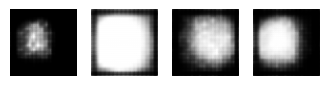

(-0.5, 399.5, 399.5, -0.5)

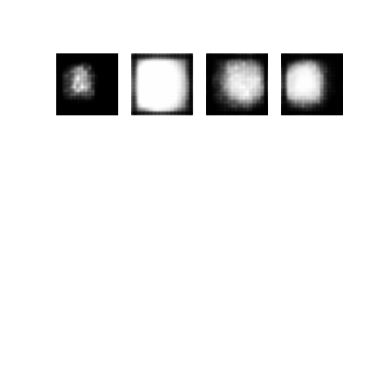

In [58]:
generate_and_save_images(
    cvae, 0, test_sample
)  # Generate images using the model and save them to a file

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(
            cvae, train_x, optimizer
        )  # Train the model using a single batch of input images
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(
            compute_loss(cvae, test_x)
        )  # Calculate the loss of the model using a single batch of input images
    elbo = -loss.result()
    display.clear_output(wait=False)
    print(
        "Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}".format(
            epoch, elbo, end_time - start_time
        )
    )
    generate_and_save_images(
        cvae, epoch, test_sample
    )  # Generate images using the model and save them to a file


# Display a generated image using the epoch number
def display_image(epoch_no: int) -> PIL.Image:
    return PIL.Image.open("image_at_epoch_{:04d}.png".format(epoch_no))


plt.imshow(display_image(EPOCHS))  # Display a generated image using the epoch number
plt.axis("off")  # Don't show the axis

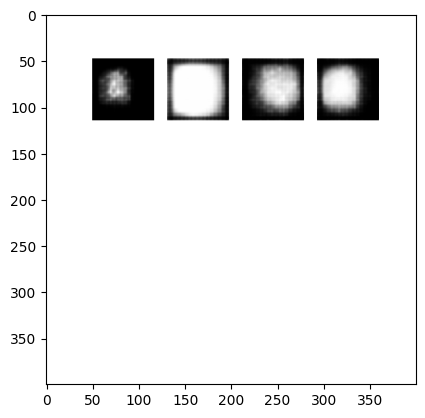

In [67]:
cvae.sample()
# Display a generated image using the epoch number
plt.imshow(display_image(EPOCHS))  # Display a generated image using the epoch number

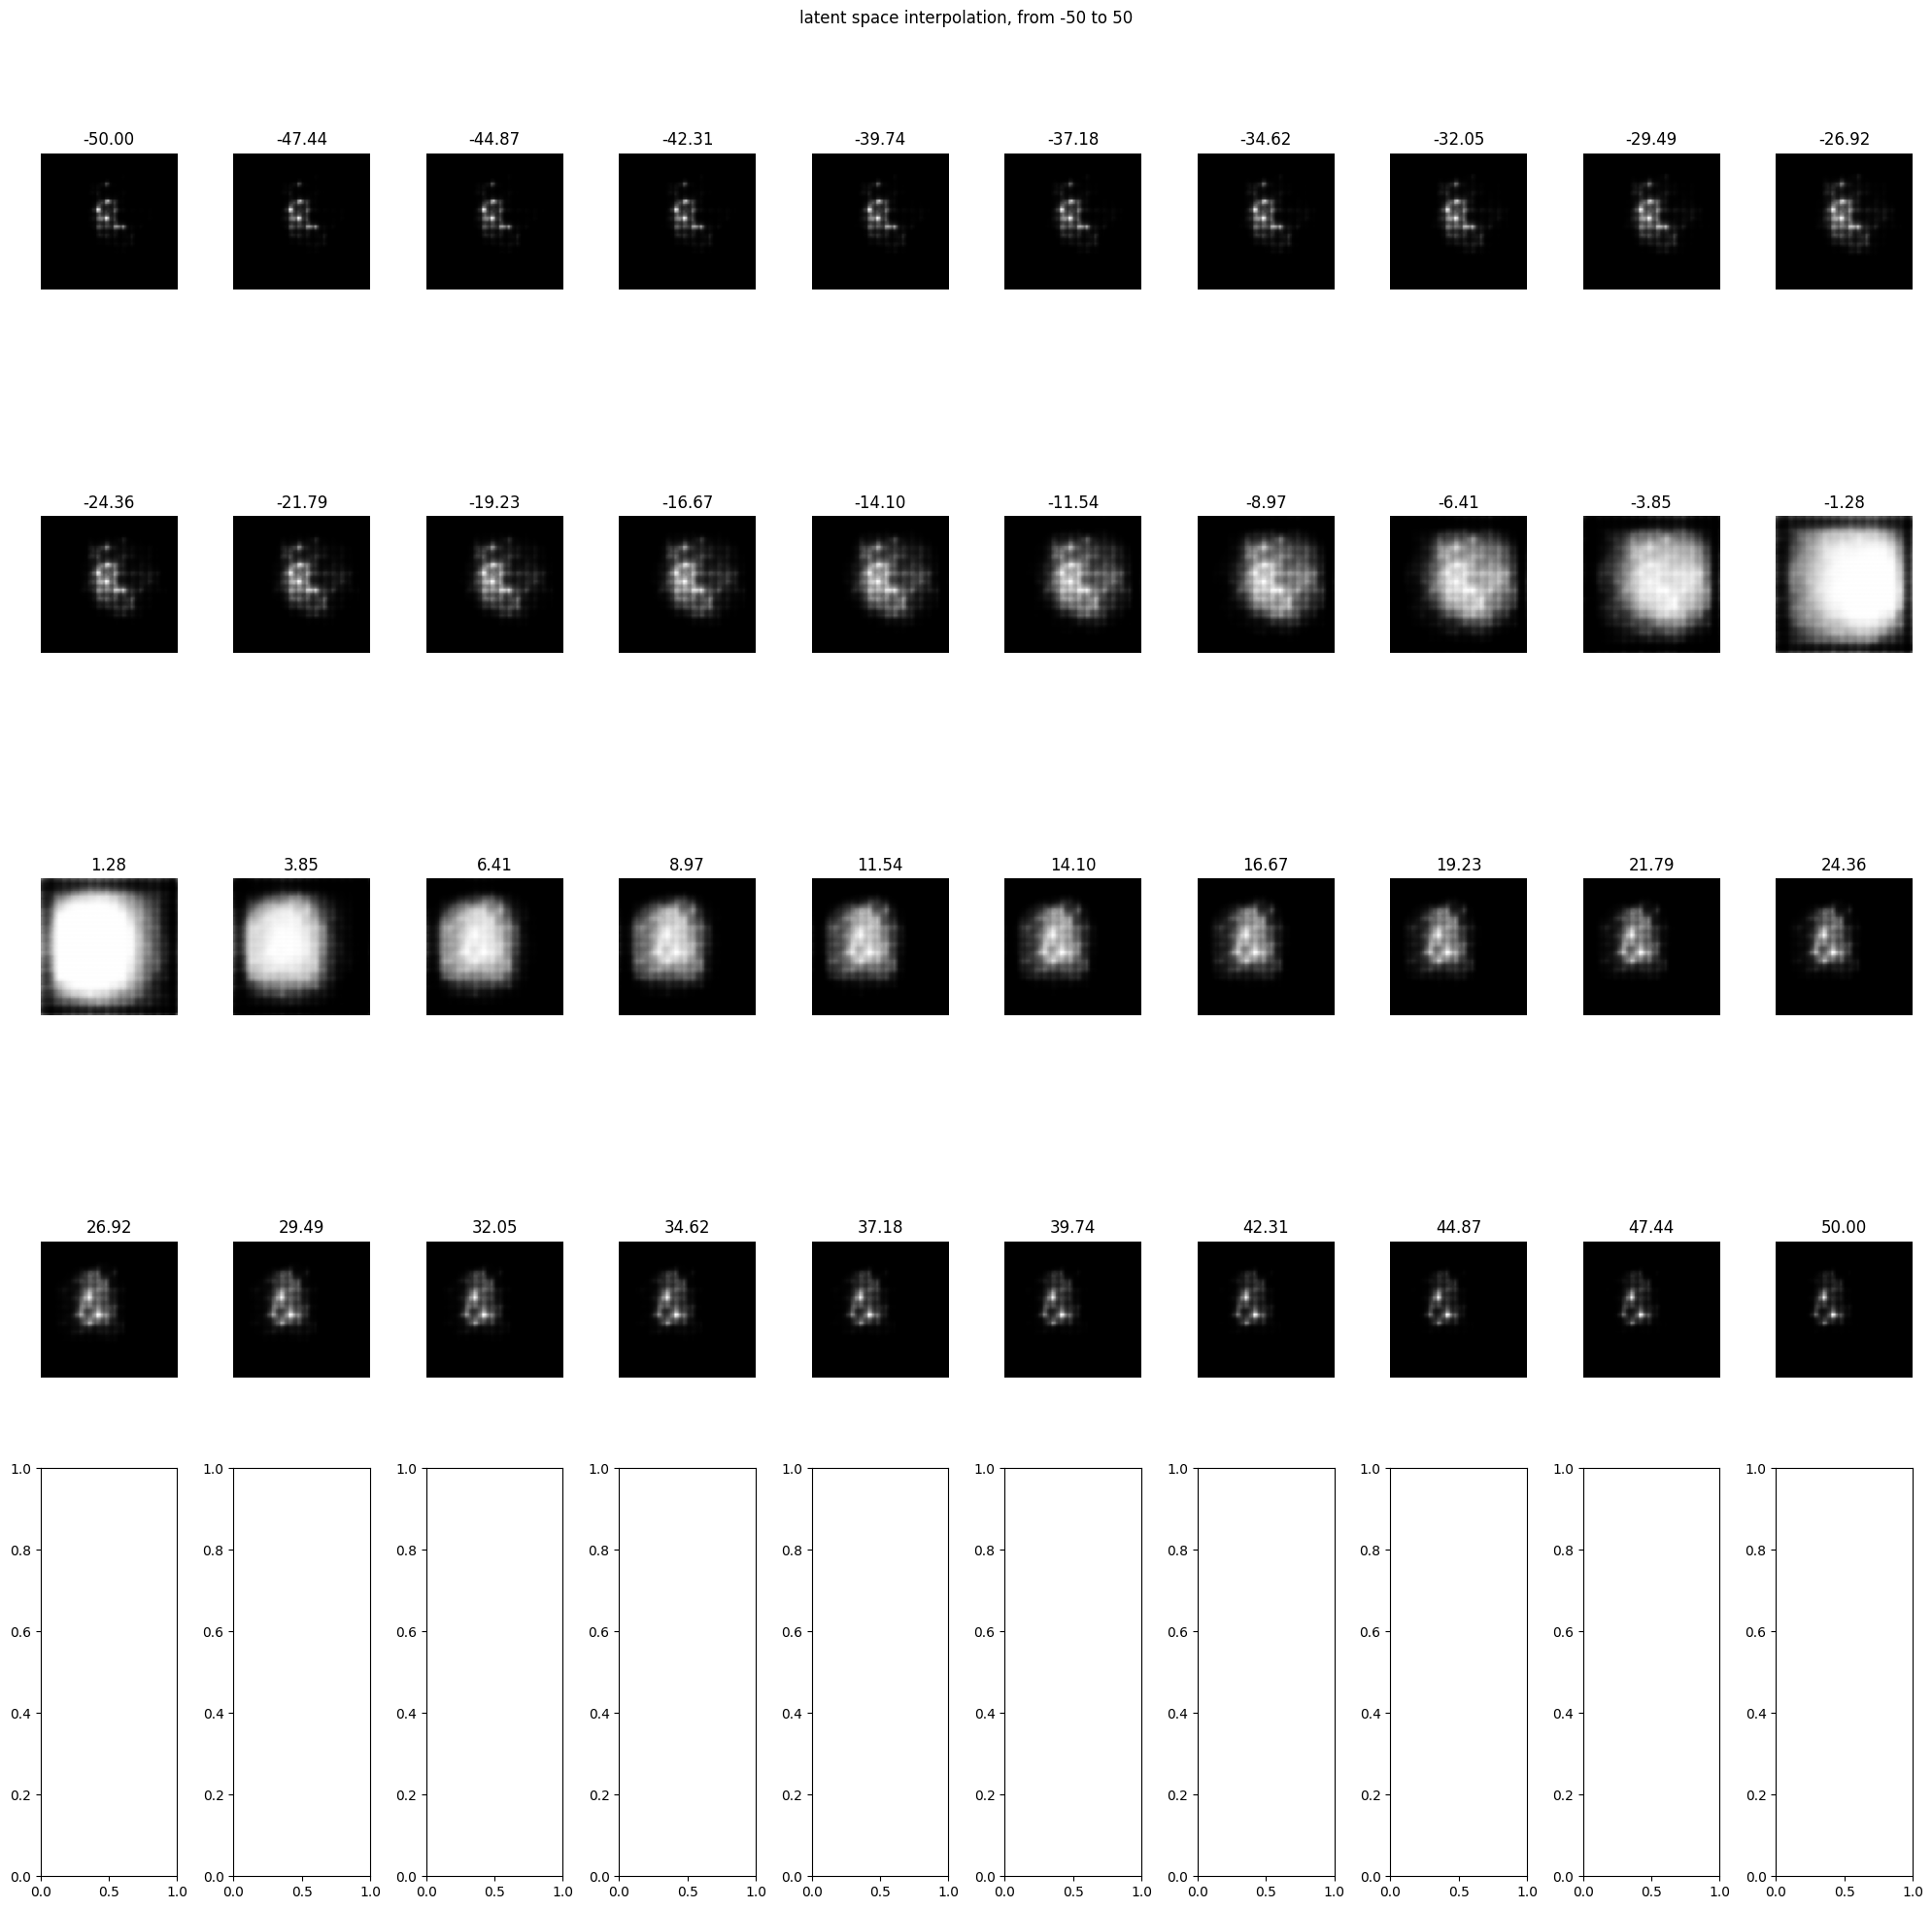

In [93]:
start = -50
end = 50
n = 40
points = np.linspace(start, end, n)

plots = np.zeros((len(points), 64, 64, 1))

for index, point in enumerate(points):
    latent_point = np.array([[point]])
    generated_data = cvae.sample(latent_point)

    plots[index] = generated_data[0]

# Plot them, with a maximum of 10 plots per line, moving to the next line after 10 plots
fig, ax = plt.subplots(n // 10 + 1, 10, figsize=(20, 20))
for i in range(n):
    ax[i // 10, i % 10].imshow(plots[i, :, :, 0], cmap="gray")
    ax[i // 10, i % 10].axis("off")
    ax[i // 10, i % 10].set_title(f"{points[i]:.2f}")
plt.suptitle(f"latent space interpolation, from {start} to {end}")
fig.tight_layout()
plt.savefig("latent_space_square_circle_1d_position_and_size.png")
plt.show()



